# Práctica 2 - CNNs

### Natalia Martínez García, Lucía Vega Navarrete
### Grupo: AP.11.06

In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import visualkeras
from keras import layers, models, regularizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [21]:
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

### 1. Carga del dataset

In [22]:
# Cargamos el dataset STL-10 ya dividido en entrenamiento y test
(train, test), info_ds = tfds.load(
    'stl10',
    split=['train', 'test'],
    as_supervised=True,  # devuelve tuplas (imagen, etiqueta)
    with_info=True # devuelve info extra del dataset (número de clases, tamaño de imagen, etc.)
)

num_clases = info_ds.features['label'].num_classes
nombres_clases = info_ds.features['label'].names
tamano_imagen = info_ds.features['image'].shape
dimension_entrada = np.prod(tamano_imagen)

print("\n" + "="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)

print(f"NOMBRE: {info_ds.name}")
print(f"\nIMÁGENES:")
print(f" - Dimensiones: {tamano_imagen}")
print(f" - Tipo: {info_ds.features['image'].numpy_dtype}")
print(f" - Longitud aplanada: {dimension_entrada}")


print(f"\nETIQUETAS:")
print(f" - Número de clases: {num_clases}")
print(f" - Clases: {', '.join(nombres_clases)}")

print(f"\nSPLITS:")
print(f" - Train: {info_ds.splits['train'].num_examples:,} imágenes")
print(f" - Test: {info_ds.splits['test'].num_examples:,} imágenes")
print(f" - Unlabelled: {info_ds.splits['unlabelled'].num_examples:,} imágenes (NO LOS USAMOS)")


INFORMACIÓN DEL DATASET
NOMBRE: stl10

IMÁGENES:
 - Dimensiones: (96, 96, 3)
 - Tipo: <class 'numpy.uint8'>
 - Longitud aplanada: 27648

ETIQUETAS:
 - Número de clases: 10
 - Clases: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

SPLITS:
 - Train: 5,000 imágenes
 - Test: 8,000 imágenes
 - Unlabelled: 100,000 imágenes (NO LOS USAMOS)


### 2. Preprocesado

Reutilizamos código de la práctrica anterior. Al tener que presentarlas imágenes como un mapa bidimensional, lo mantenemos en su forma orginial. 
Como antes teníamos las imágenes aplanadas, usábamos np.array() para pasarlo a numpy. Ahora como tenemos las dimansiones originales, tenemos que usar tf.stack()

In [23]:
def preprocesado(imagen, etiqueta):
    imagen = tf.cast(imagen, tf.float32) / 255.0  # imagen a float32 y escala [0,1]
    etiqueta = tf.one_hot(etiqueta, depth = num_clases) # one-hot encoding
    return imagen, etiqueta

def preprocesado_dataset(dataset):
    # Creamos listas vacías donde almacenaremos las imágenes y etiquetas preprocesadas.
    imagenes = []
    etiquetas = []

    for img, label in dataset: 
        imagen, etiqueta = preprocesado(img, label) # Aplicamos el preprocesado a cada muestra 
        # Añadimos los resultafos a las listas 
        imagenes.append(imagen)
        etiquetas.append(etiqueta)

    # Convertimos a arrays de numpy (manteniendo las 3 dimensiones)
    return tf.stack(imagenes).numpy(), tf.stack(etiquetas).numpy() 

# Aplicamos la funcion a los conjuntos de entrenamiento y test
train_inputs, train_targets = preprocesado_dataset(train)
test_inputs, test_targets = preprocesado_dataset(test)


print("Shape de train_inputs:", train_inputs.shape)
print("Shape de train_targets:", train_targets.shape)

Shape de train_inputs: (5000, 96, 96, 3)
Shape de train_targets: (5000, 10)


####  División del dataset 

In [24]:
# Permutación aleatoria de índices para mezclar los datos
# Para que la división train/validation sea aleatoria
indices_permutation = np.random.permutation(len(train_inputs))
shuffled_inputs = train_inputs[indices_permutation]
shuffled_targets = train_targets[indices_permutation]

# Calculamos cuántas muestras coger para validación (20% del de entrenamiento)
num_validation_samples = int(0.2 * len(train_inputs))

# Separamos el primer 20% para validación
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
# El resto se mantiene para entrenamiento
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

### 3. Creación y entrenamiento de modelos

In [25]:
def entrenar(modelo, train, val, test, epochs=15):
    
    # Desempaquetamos los conjuntos de datos
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test
    
    # Entrenamos el modelo
    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        batch_size=128
    )
    
    # Evaluamos el modelo en test y mostramos resultados
    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)
    
    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    return history, loss, acc, prec, rec, f1

In [26]:
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    # Crear figura con 2 subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfica de accuracy
    ax1.plot(epochs, accuracy, "b-o", label="Training accuracy")
    ax1.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfica de loss
    ax2.plot(epochs, loss, "b-o", label="Training loss")
    ax2.plot(epochs, val_loss, "r--o", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### 3.1. Modelo 1 - CNN base 


In [43]:
# copié el ejemplo del lab 6 del punto 6.4.1, vamos cambiando cosas luego 
def cnn_base(input_shape, num_classes):
    
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation="relu", padding="same")(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    cnn_base = models.Model(inputs, outputs, name="cnn_base")
    return cnn_base

# Construcción con TUS variables
cnn_base = cnn_base(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
cnn_base.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy', 
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),  
    metrics.F1Score(name='f1_score', average='macro')
])

cnn_base.summary()


Model: "cnn_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │       737,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,538 (3.17 MB)

 Trainable params: 830,538 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.2645 - f1_score: 0.2477 - loss: 1.9973 - precision: 0.6619 - recall: 0.0347 - val_accuracy: 0.2700 - val_f1_score: 0.2064 - val_loss: 1.9380 - val_precision: 0.4605 - val_recall: 0.1400
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.4223 - f1_score: 0.4103 - loss: 1.6076 - precision: 0.7211 - recall: 0.1590 - val_accuracy: 0.3570 - val_f1_score: 0.3253 - val_loss: 1.6674 - val_precision: 0.5569 - val_recall: 0.1810
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.4967 - f1_score: 0.4878 - loss: 1.4168 - precision: 0.7496 - recall: 0.2470 - val_accuracy: 0.4060 - val_f1_score: 0.3916 - val_loss: 1.5789 - val_precision: 0.6287 - val_recall: 0.2150
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.5525 - f1_score: 0.5471 - loss: 1.2708 - precision: 0.7843 - recall: 0.3162 - val_accuracy: 0.4120 - val_f1_score: 0.3947 - val_loss: 1.5612 - val_precision: 0.6209 - val_recall:

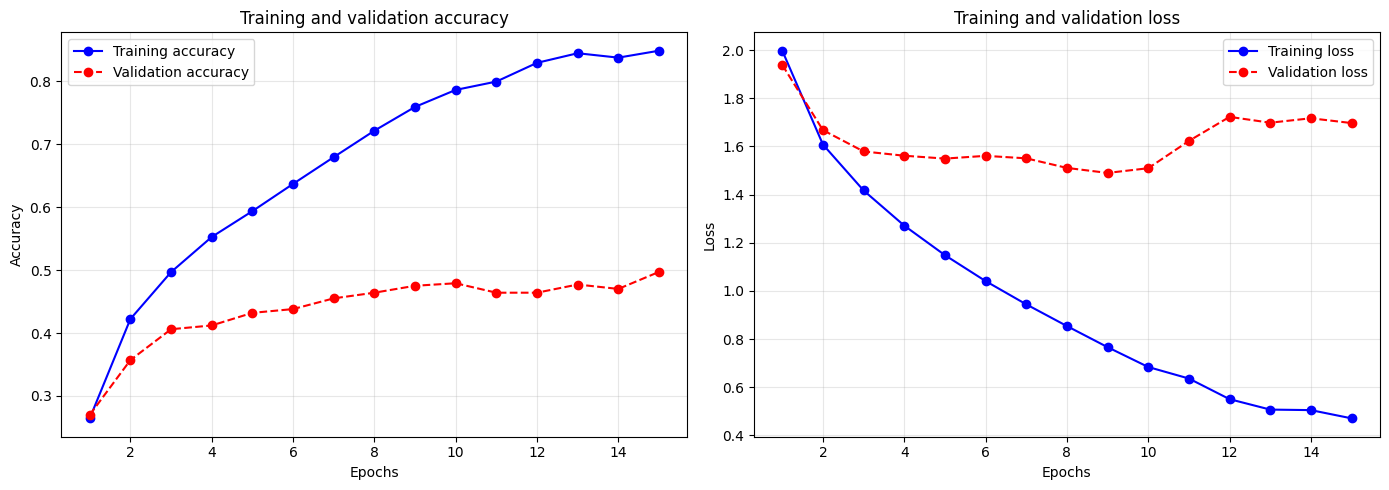

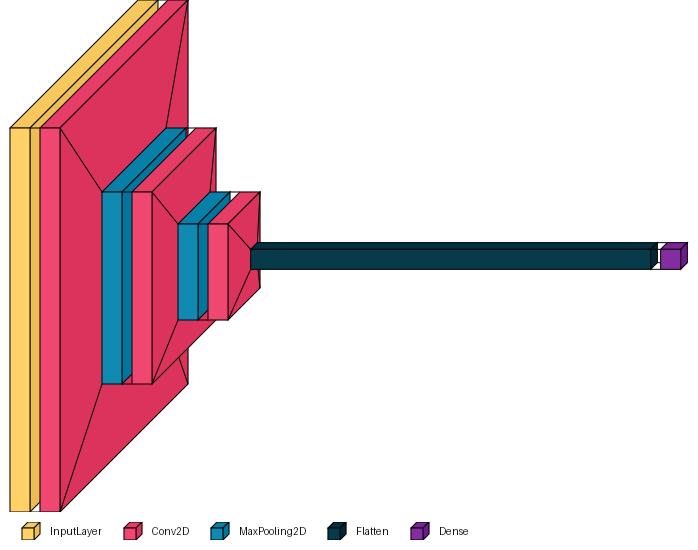

In [44]:
hist_base, loss_base, acc_base, prec_base, rec_base, f1_base= entrenar(
    cnn_base, 
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets),
)

plot(hist_base)  
visualkeras.layered_view(cnn_base, legend=True)

#### 3.2 Modelo 2 - Data augmentation (ns si al añadirlo ya se considera otro modelo o hay que ponérselo al base y no contarlo)

In [47]:
# esto lo cogí del lab 6, pone en el enunciado que hagamos aumento de datos. esto lo aplica luego al ppo del modelo, despés del input
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [48]:
# copié el ejemplo del lab 6 del punto 6.4.1, vamos cambiando cosas luego 
def data_aug(input_shape, num_classes):
    
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation="relu", padding="same")(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    data_aug = models.Model(inputs, outputs, name="data_augmentation")
    return data_aug

# Construcción con TUS variables
data_aug = data_aug(tamano_imagen,num_clases)

# Si quieres, después le añades tus métricas de Precision/Recall/F1.
data_aug.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy', 
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),  
    metrics.F1Score(name='f1_score', average='macro')
])

data_aug.summary()


Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │       737,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,538 (3.17 MB)

 Trainable params: 830,538 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.2635 - f1_score: 0.2443 - loss: 2.0444 - precision: 0.7059 - recall: 0.0210 - val_accuracy: 0.3070 - val_f1_score: 0.2693 - val_loss: 1.8626 - val_precision: 0.5376 - val_recall: 0.1430
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.4283 - f1_score: 0.4173 - loss: 1.5866 - precision: 0.7229 - recall: 0.1650 - val_accuracy: 0.3520 - val_f1_score: 0.3203 - val_loss: 1.6987 - val_precision: 0.5200 - val_recall: 0.1820
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.5063 - f1_score: 0.4966 - loss: 1.3841 - precision: 0.7518 - recall: 0.2545 - val_accuracy: 0.4250 - val_f1_score: 0.4084 - val_loss: 1.5535 - val_precision: 0.6069 - val_recall: 0.2300
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.5552 - f1_score: 0.5504 - loss: 1.2416 - precision: 0.7838 - recall: 0.3290 - val_accuracy: 0.4550 - val_f1_score: 0.4408 - val_loss: 1.4847 - val_precision: 0.6376 - val_recall:

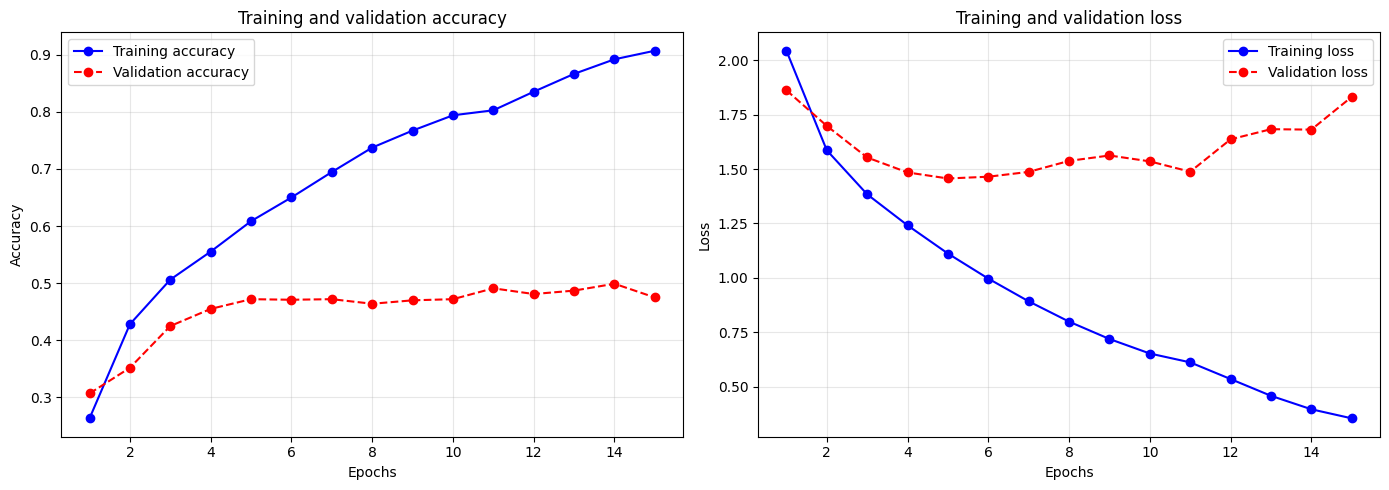

c:\Users\NataliaUDC\anaconda3\envs\AP-311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


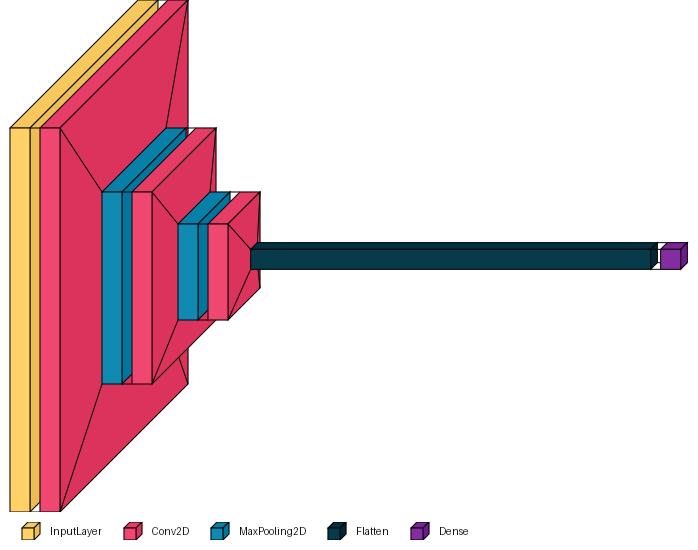

In [49]:
hist_data_aug, loss_data_aug, acc_data_aug, prec_data_aug, rec_data_aug, f1_data_aug= entrenar(
    data_aug, 
    (training_inputs, training_targets),(val_inputs, val_targets),(test_inputs, test_targets),
)

plot(hist_data_aug)  
visualkeras.layered_view(data_aug, legend=True)